In [1]:
import numpy as np
from numpy import Inf
import sys

##  exp
sys.path.append("/u/svarel/exp/build/utils/Analysis/")
from spherical_basis_builder import *
import simpleSL

## Auriga
import LibAu as la


Load Halo

In [2]:
nhalo=21 #Name Halo
nsnap= 63 #z=0
sim = la.Reader_Au(Nhalo=nhalo,Nsnap=nsnap) #Read Simulation
header = sim.Header()
h=header['hubbleparam']
sc=header['time']

Rvir =sim.sf.data['frc2'][0]*1000*sc/h
Mvir =sim.sf.data['fmc2'][0]*1e10/h
print(Mvir,Rvir)

fields_stars = ['pos','vel','id','mass','type','pot','age']
Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)


fields_dm = ['pos','vel','id','mass','type','pot']
DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
#Rotate Halo
Data = {'stars':Datstars,'dm1':DatDM}
param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
gal = la.ToolRot(Data=Data, param=param)
Data = gal.Rotate()

Datstars=Data['stars']
DatDM = Data['dm1']

potdm = DatDM['pot']

2088654433553.4023 349.25210558595916


/u/svarel/.local/lib/python3.6/site-packages/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


In [3]:
pos = DatDM['pos'] #part_rot[not_in_subs]
mass = DatDM['mass']  #part['dark']['mass'][not_in_subs]
print(np.sum(mass), mass[0], len(pos), len(mass))
M_tot = np.sum(mass)

#selecting 1million random particles
ind = np.arange(0,len(mass),1,dtype=int)
sel = np.random.choice(ind, 1000000, replace=False).astype(int)
pos,mass = pos[sel],mass[sel]

rr = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
rbins,dreturn = return_density(np.log10(rr), 1., rangevals=[0., 2.5],bins=100)
R,D,M,P = makemodel_empirical(rbins, dreturn, M=1.,pfile='m12b_SPHLbasis_empirical.txt')
'''
R           : (array of floats) the radius values
D           : (array of floats) the density
M           : (array of floats) the mass enclosed
P           : (array of floats) the potential'''

# Build the basis
ebf = simpleSL.slfunctions('./m12b_SPHLbasis_empirical.txt',5,10,0.,2.5, 2000)

# Compute the coefficients using the empirical basis function ebf
coefficients = simpleSL.coefsl(mass, pos[:,0], pos[:,1], pos[:,2],  './m12b_SPHLbasis_empirical.txt',2,6)
print(np.shape(ebf))
print(np.shape(coefficients))


1909857200000.0 60622.2 31503466 31503466
! Scaling:  R= 307.25573652674484   M= 1.0   M0= 818709.8711298575   R0= 307.25573652674484
1.0 1.2214339111606823e-06 1.221433911160682e-06 1.2214339111606823e-06
(36, 10, 2000)
(9, 6)


Text(0.5, 0, 'R')

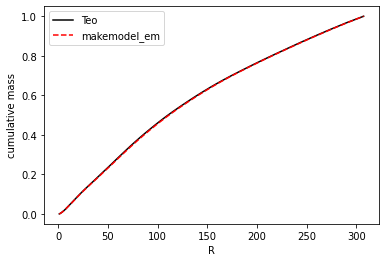

In [4]:
dm = (4/3)*np.pi*dreturn*rbins**3
Macc = np.cumsum(dm)/np.sum(dm)
rmax = np.nanmax(rbins)
plt.subplot(111)
plt.plot(rbins,Macc,color='k',label='Teo')
plt.plot(R, M,c='r',ls='--', label='makemodel_em')
plt.legend()
plt.ylabel('cumulative mass')
plt.xlabel('R')

4.5433154170959243e-39


Text(0.5, 0, 'R')

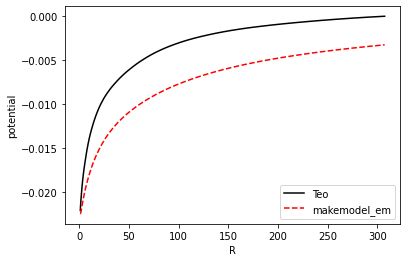

In [5]:
G= 6.674*1e-11 #m3⋅kg−1⋅s−2
m2kpc, kg2Msun = 3.2408*1e-20,5e-31
G=G*(m2kpc**3) /kg2Msun # kpc3 Msun-1 s-2
print(G)
#pvals = -mvals/(rvals+1.e-10) - (pwvals[dvals.size-1] - pwvals)
dm = (4/3)*np.pi*dreturn*rbins**3
Pw = dm/rbins
Pwacc = ((-Macc/rbins) - (np.sum(Pw)-np.cumsum(Pw)))  *(1/np.sum(dm))
plt.subplot(111)

plt.plot(rbins,Pwacc,color='k',label='Teo')
plt.plot(R, P,c='r',ls='--', label='makemodel_em')
plt.legend()
plt.ylabel('potential')
plt.xlabel('R')

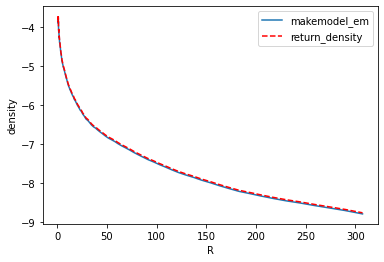

In [6]:
km2kpc = 3.24078e-17

plt.subplot(111)
plt.plot(R, np.log10(D), label='makemodel_em')
plt.plot(rbins,np.log10(dreturn*(2*np.pi/np.sum(dm))),c='r',ls='--',label='return_density')
plt.ylabel('density')
plt.xlabel('R')
plt.legend()


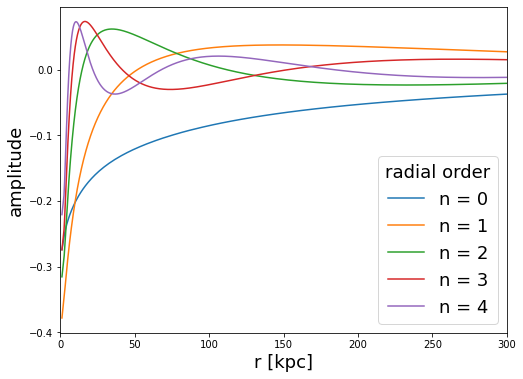

In [7]:
xvals = 10.**(np.linspace(0,2.5, 2000))
plt.figure(figsize=(8,6))
for n in range(0,5):
    plt.plot(xvals, ebf[0][n],label='n = %s'%n)
plt.legend(title='radial order',fontsize=18,title_fontsize=18)
#plt.savefig('testfig.png')
plt.xlabel('r [kpc]',fontsize=18)
plt.ylabel('amplitude',fontsize=18)
plt.xlim(0,300)
plt.show()
plt.close()

In [8]:
from exptool.utils import halo_methods
from exptool.basis import spheresl
def compute_density(coordinates, expcoef):
    # den0 is the monopole contribution to the density
    # den1 is the l>0 contribution to the densityx`
    # (therefore, the total density is den0+den1)
    # pot0 is the monopole contribution to the potential
    # pot1 is the l>0 contribution to the potential
    # potr is the radial force
    # pott is the polar force
    # potp is the azimutuhal force

    # specify your cache generated by simpleSL
    sph_file = './.slgrid_sph_cache'

    # specify your spherical model file (input to simpleSL)
    mod_file = './m12b_SPHLbasis_empirical.txt'

    # pull in the cache data
    lmax, nmax, numr, cmap, rmin, rmax, scale, ltable, evtable, eftable = halo_methods.read_cached_table(sph_file)
    xi, rarr, p0, d0 = halo_methods.init_table(mod_file, numr, rmin, rmax, cmap, scale)

    # specify the coefficient array: you will not have to do this, because you already have the coefficients in the correct format
    # from simpleSL.coefsl()
    #llmax = (lmax+1)*(lmax+1)
    #expcoef = np.zeros([llmax,nmax])

    # make some mock coefficient values
    #expcoef[0][0] = 6.0
    #expcoef[1][0] = 0.01

    # specify coordinate
    #r     = 0.01 # 3d radius
    #costh = 0.0  # = z/r, polar coordinate
    #phi   = 0.0  # azimuth
    r, costh, phi = coordinates[0], coordinates[1], coordinates[2]
    # evaluate fields at a specifc point
    den0,den1,pot0,pot1,potr,pott,potp = spheresl.all_eval(r, costh, phi, expcoef,xi,p0,d0,cmap,scale,lmax,nmax,evtable,eftable)
    return den0, den1,pot0,pot1

In [57]:
#from multiprocessing import Pool
import multiprocessing
import ctypes
import pandas as pd

x = np.linspace(pos[:,0].min(), pos[:,0].max(),100)
y = np.linspace(pos[:,1].min(), pos[:,1].max(),100)
xgrid, ygrid = np.meshgrid(x, y)


den_mon = pd.DataFrame(np.zeros_like(xgrid))
den_nonmon = df = pd.DataFrame(np.zeros_like(xgrid))


pot_mon = np.zeros_like(xgrid)
pot_nonmon = np.zeros_like(xgrid)

Hden,Hpot= np.zeros_like(xgrid),np.zeros_like(xgrid)
#_________________________________________________________________

def multifunc(ii,Nj,d1,d2):
    #ii,C=L
    for jj in range(Nj):
        r = np.sqrt(xgrid[ii][jj]**2 + ygrid[ii][jj]**2)
        phi = np.arctan2(ygrid[ii][jj], xgrid[ii][jj])
        d1[ii][jj], d2[ii][jj],pot_mon[ii][jj],pot_nonmon[ii][jj] = compute_density([r, 0, phi], coefficients)
        #d['den_mon'][ii][jj]=algo
        #d['den_nonmon'][ii][jj]=algo2
        #print(algo,d['den_mon'][ii][jj])

Npx=50
ncore=10


manager = multiprocessing.Manager()
return_dict = manager.dict()
return_dict['den_mon']=np.zeros_like(xgrid).tolist()
return_dict['den_nonmon']=np.zeros_like(xgrid).tolist()
jobs=[]
for i in range(0,int(Npx/ncore)):
    jobs=[]
    for p in range(ncore):
        p1 = multiprocessing.Process(target=multifunc, args=((i*10)+p,Npx,den_mon , den_nonmon ))#args=([(i*10)+p,col]) )
        jobs.append(p1)
        p1.start()
        
        #for p_ in jobs:
        #    p_
        
        #p = Pool(ncore)
        #L_ = [[(i*10)+k,col] for k in range(ncore)]
        #R = p.map(multifunc, L_)
        #sl = np.array(R)
        #p.close()
        #p.join()
    for x in jobs: x.join()
    #den_mon=return_dict['den_mon']
    #den_nonmon=return_dict['den_nonmon']

#for i in range(100):
#    for j in range(100):
#        r = (xgrid[i][j]**2 + ygrid[i][j]**2)**0.5
#        phi = np.arctan2(ygrid[i][j], xgrid[i][j])
#        den_mon[i][j], den_nonmon[i][j],pot_mon[i][j],pot_nonmon[i][j] = compute_density([r, 0, phi], coefficients)
        
        
        
#Xgrid = rgrid * np.cos(thetagrid)
#Ygrid = rgrid * np.sin(thetagrid)
    
#fig, ax = plt.subplots(1, 1)
#ax.contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)))
#fig.savefig("2d_density.png", bbox_inches='tight')
#plt.show()
#plt.close()

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.1547819

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02][ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]

[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.15478198e+00  1.69744838e-04  2.82439622e-04 -2.24912772e-02]
[ 1.154781

In [59]:
#den_mon=return_dict['den_mon']
#den_nonmon=return_dict['den_nonmon']
np.array(return_dict['den_mon'])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


TypeError: Shapes of x (100, 100) and z (200, 100) do not match

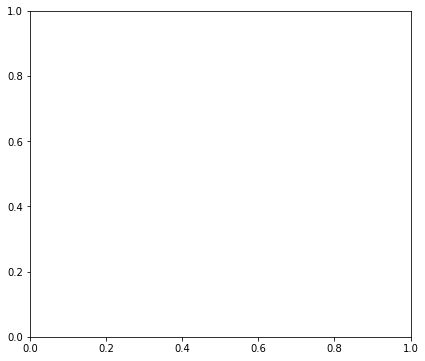

In [52]:
plt.figure(figsize=(15,6))
#fig, ax = plt.subplots(1, 1)
ax = plt.subplot(121)
ax.contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)),60)
#fig.savefig("2d_density.png", bbox_inches='tight')

ax=plt.subplot(122)
H,_x,_y,box = la.StellarDensity2D(pos[:,0],pos[:,1],mass,npix = [100,100],style='SD')

ax.patch.set_facecolor('black')
extent = _x.min(),_x.max(),_y.min(),_y.max()
plt.imshow(np.log10(H).T,cmap='cubehelix',extent=extent,aspect='auto',origin='lower',interpolation='none')
plt.scatter(0,0,s=20,c='r',marker='+')
plt.show()
plt.close()

In [12]:
from scipy.stats import binned_statistic_2d
plt.figure(figsize=(15,6))
#fig, ax = plt.subplots(1, 1)

#ax2=plt.subplot(122)
#H,_x,_y,box = la.StellarDensity2D(pos[:,0],pos[:,1],potdm[sel]*km2kpc,npix = [400,400],style='normal',statistic='median')
H, _x, _y, _ = binned_statistic_2d(pos[:,0],pos[:,1], potdm[sel]*km2kpc**2, 'median', bins=[100,100])
#plt.scatter(pos[:,0],pos[:,1],c=potdm[sel]*km2kpc, s=1)
#ax2.patch.set_facecolor('black')
#extent = _x.min(),_x.max(),_y.min(),_y.max()
#plt.imshow(H.T,cmap='bgr',extent=extent,aspect='auto',origin='lower')#,interpolation='none')
#plt.scatter(0,0,s=20,c='r',marker='+')
#plt.colorbar()

#ax1 = plt.subplot(121)
#ax1.contourf(xgrid, ygrid, np.log10(np.abs(pot_mon + pot_nonmon)),60)
#fig.savefig("2d_density.png", bbox_inches='tight')
#ax1.colorbar().remove()
#plt.show()
#plt.close()

<Figure size 1080x432 with 0 Axes>

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


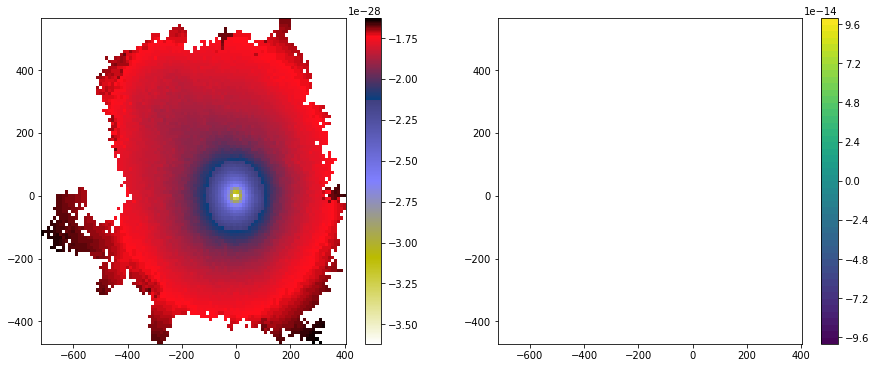

In [13]:

fig, ax = plt.subplots(1, 2, figsize=(15,6))
im = ax[0].imshow(H.T,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern_r')
plt.colorbar(im, ax=ax[0])

#ax1 = plt.subplot(121)
im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(pot_mon + pot_nonmon)),60)
plt.colorbar(im2, ax=ax[1])
#plt.show()
#plt.close()

In [14]:
mask = np.isnan(H.T)

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


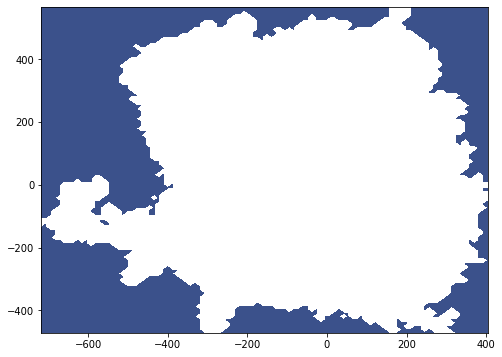

In [15]:
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
potmask =  np.copy(np.log10(np.abs(pot_mon + pot_nonmon)))
potmask[mask] =  0
ax.contourf(xgrid, ygrid, potmask,100)

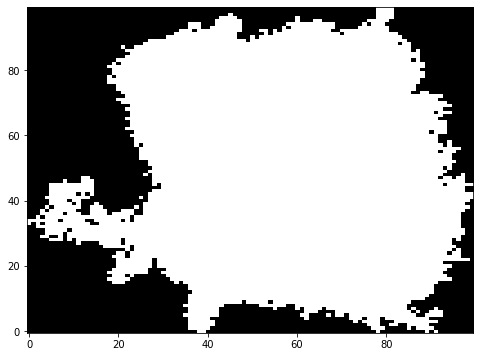

In [16]:
plt.figure(figsize=(8,6))
plt.imshow(potmask,aspect='auto',origin='lower',interpolation='none',cmap='nipy_spectral')

In [31]:
import multiprocessing


def worker(procnum, return_dict):
    """worker function"""
    print(str(procnum) + " represent!")
    return_dict[procnum] = procnum


if __name__ == "__main__":
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs = []
    for i in range(5):
        p = multiprocessing.Process(target=worker, args=(i, return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    print(return_dict.values())

0 represent!
1 represent!
2 represent!
3 represent!
4 represent!
[0, 1, 2, 3, 4]
